# Task 3

In [1]:
import Data 
import requests
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from io import BytesIO
import numpy as np 
from glob import glob
from Data import getIDA2Prices
import matplotlib.pyplot as plt

In [2]:
path = "/Users/lukaandrensek/Documents/gen_i/TradingChallenge_Task2/Task2_11_15.csv"


In [4]:
df = pd.read_csv(path, header=None)
df.columns = ["DeliveryDateTime", "Price_ida2"]
df["DeliveryDateTime"] = pd.to_datetime(df["DeliveryDateTime"])
df = df.set_index("DeliveryDateTime")

In [5]:
ida2 = getIDA2Prices()
ida2 = ida2.set_index("DeliveryDateTime")


In [6]:
d1 = pd.to_datetime("2024-10-6 00:00:00")
d2 = d1 + pd.Timedelta(hours=24)
d0 = d1 - pd.Timedelta(hours=24)
loc_d1 = d1.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
loc_d2 = d2.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')
loc_d0 = d0.tz_localize('Europe/Ljubljana', ambiguous='NaT', nonexistent='NaT')

In [7]:
mask = (loc_d1 <= ida2.index) & (ida2.index < loc_d2)
ida2 = ida2[mask]


# Are we for real

In [8]:
ida2 = df

# Are we for real

In [9]:
c = (ida2.copy()).values
prices = (ida2.copy()).values

c = list(c.flatten())


In [10]:
P = 10 # max_power = 10 MW
Q = 20 # capacity = 20 MWh
t = 0.25 # 15 minutes
c = [-t * x for x in c]

In [11]:
n = len(c)

identity_matrix = np.eye(n)
identity_matrix_list = identity_matrix.tolist()
I = identity_matrix_list

neg_identity_matrix = -np.eye(n)
neg_identity_matrix_list = neg_identity_matrix.tolist()
neg_I = neg_identity_matrix_list

triangular_matrix = t * np.tri(n)
triangular_matrix_list = triangular_matrix.tolist()
A = triangular_matrix_list

neg_triangular_matrix = -t * np.tri(n)
neg_triangular_matrix_list = neg_triangular_matrix.tolist()
neg_A = neg_triangular_matrix_list

one_vec = [n * [1.0]]
neg_one_vec = [n * [-1.0]]



matrike = [I, neg_I, A, neg_A, one_vec, neg_one_vec]
A_ub = []
for m in matrike:
    A_ub.extend(m)

b = ([P] * n) + ([P] * n) + ([Q] * n) + ([0] * n) + ([0] * 2)

bounds = [(None, None)] * n 


In [12]:
from scipy.optimize import linprog

neg_c = [-1 * x for x in c]

# Solve the linear programming problem
result = linprog(neg_c, A_ub=A_ub, b_ub=b, bounds=bounds, method='highs')

# Display the results
if result.success:
    print("Optimal value (maximized):", -result.fun)  # Negate to reflect maximization
    #print("Optimal solution:", result.x)
else:
    print("The problem could not be solved:", result.message)


Optimal value (maximized): 5193.744089840267


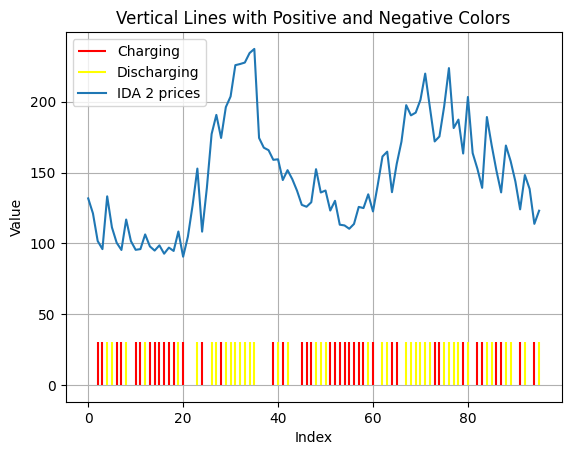

In [13]:

array = result.x  # Assuming result.x is available
x = np.arange(len(array))

# Separate positive and negative values
positive_indices = array >= 0
negative_indices = array < 0

# Plot vertical lines for positive values
plt.vlines(x[positive_indices], ymin=0, ymax=array[positive_indices] * 3, color='red', label='Charging')

# Plot vertical lines for negative values
plt.vlines(x[negative_indices], ymin=0, ymax=-array[negative_indices] * 3, color='yellow', label='Discharging')

plt.plot(prices, label = "IDA 2 prices")

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Vertical Lines with Positive and Negative Colors')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


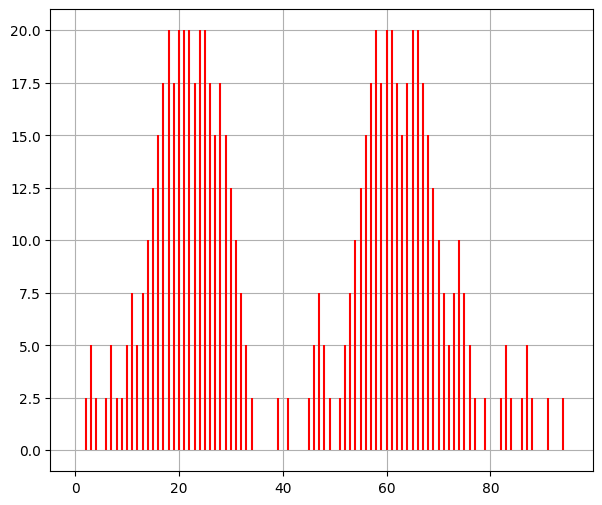

In [14]:
current_charge = np.cumsum( t * array)

plt.figure(figsize=(7, 6))
x = np.arange(len(current_charge))

plt.vlines(x, ymin=0, ymax=current_charge, color='red', label='Current charge')
plt.grid(True)
plt.show()

In [15]:
charge_schedule = result.x
yhat = pd.Series(data = charge_schedule, index = ida2.index)

In [16]:
dates = yhat.index
values = yhat.values
dates = dates.strftime('%Y-%m-%dT%H:%M:%S')
result = pd.DataFrame({
    "ProductStartCET" : dates, 
    "Forecast" : values
})
result

,ProductStartCET,Forecast
0,2024-11-15T00:00:00,-0.0
1,2024-11-15T00:15:00,-0.0
2,2024-11-15T00:30:00,10.0
3,2024-11-15T00:45:00,10.0
4,2024-11-15T01:00:00,-10.0
...,...,...
91,2024-11-15T22:45:00,10.0
92,2024-11-15T23:00:00,-10.0
93,2024-11-15T23:15:00,-0.0
94,2024-11-15T23:30:00,10.0


In [17]:
cond = True
if cond:
    result.to_csv("Task3_11_15.csv", index=False, header=False,sep=',')

In [ ]:
n = len(c)

triangular_matrix = t * np.tri(n)
triangular_matrix_list = triangular_matrix.tolist()
A = triangular_matrix_list

neg_triangular_matrix = -t * np.tri(n)
neg_triangular_matrix_list = neg_triangular_matrix.tolist()
neg_A = neg_triangular_matrix_list

matrike = [A, neg_A]
A_ub = []
for m in matrike:
    A_ub.extend(m)


b = ([Q] * n) + ([0] * n)

bounds = [(-P, P)] * n 

In [291]:
from scipy.optimize import linprog

# Solve the linear programming problem
result = linprog(neg_c, A_ub=A_ub, b_ub=b, bounds=bounds, method='highs')

# Display the results
if result.success:
    print("Optimal value:", -result.fun)  
    print("Optimal solution: ", result.x)
else:
    print("The problem could not be solved:", result.message)

Optimal value: 12275.875000000002
Optimal solution:  [ -0.  -0.  10.  10.  10. -10.  10.  10.  10. -10.  10.  10. -10. -10.
  10.  10.  10. -10. -10.  10.  10.  10.  -0.  -0. -10.  10. -10. -10.
 -10. -10. -10. -10. -10. -10.  10.  10. -10. -10.  10.  10. -10. -10.
  -0.  10. -10.  -0.  -0.  10. -10.  10.  10.  10. -10. -10.  10.  10.
  10.  10.  10.  -0.  10. -10. -10. -10.  10.  10.  10.  10. -10. -10.
  10.  10. -10.  -0. -10. -10. -10. -10. -10. -10. -10.  -0.  10.  10.
 -10.  -0. -10.  10. -10.  -0.  -0.  10. -10.  -0.  -0.  -0.]


In [292]:
n = len(c)

triangular_matrix = t * np.tri(n)
triangular_matrix_list = triangular_matrix.tolist()
A = triangular_matrix_list

neg_triangular_matrix = -t * np.tri(n)
neg_triangular_matrix_list = neg_triangular_matrix.tolist()
neg_A = neg_triangular_matrix_list

matrike = [A, neg_A]
A_ub = []
for m in matrike:
    A_ub.extend(m)


b = ([Q] * n) + ([0] * n)


In [293]:
import cvxpy as cp

# Define the problem size
n = len(c)  # Number of variables

# Define decision variables
x = cp.Variable(n)

# Define the objective function (maximize 3x1 + 5x2)
objective = cp.Maximize(c @ x)

# Define the constraints

constraints = [np.array(A_ub) @ x <= np.array(b), -P <= x, x <= P]

# Formulate and solve the problem
problem = cp.Problem(objective, constraints)
result = problem.solve()

# Display the results
print("Optimal value (maximized):", result)
print("Optimal solution:", x.value)


Optimal value (maximized): 12275.874999254105
Optimal solution: [ 5.14059853e-09 -1.45013063e-09  9.99999995e+00  9.99999999e+00
  9.99999998e+00 -9.99999998e+00  9.99999989e+00  1.00000000e+01
  9.99999999e+00 -9.99999997e+00  9.99999999e+00  1.00000000e+01
 -1.00000000e+01 -1.00000000e+01  9.99999994e+00  9.99999999e+00
  1.00000000e+01 -9.99999978e+00 -9.99999998e+00  9.99999999e+00
  1.00000000e+01  9.99999999e+00  2.43033496e-09 -4.73342621e-09
 -4.75340267e+00  4.75340267e+00 -1.00000000e+01 -1.00000000e+01
 -1.00000000e+01 -1.00000000e+01 -1.00000000e+01 -9.99999999e+00
 -1.00000000e+01 -1.00000000e+01  1.00000000e+01  1.00000000e+01
 -1.00000000e+01 -1.00000000e+01  9.99999989e+00  1.00000000e+01
 -9.99999999e+00 -9.99999989e+00  5.47062723e-09  9.99999999e+00
 -9.99999996e+00 -3.44670745e-08  1.20112123e-09  1.00000000e+01
 -1.00000000e+01  9.99999992e+00  9.99999999e+00  1.00000000e+01
 -1.00000000e+01 -9.99999998e+00  9.99999996e+00  1.00000000e+01
  1.00000000e+01  9.999999